Results directory: C:\Users\Boris\Desktop\code\multilingual-rag\results
Loading: multilingual_rag_results.csv
Loaded 60 experiment results
Hindi results: 30
Chinese results: 30
✓ All required columns present

Validating data quality...
Hindi:
  Empty multilingual responses: 0
  Empty translation responses: 0
  Empty multilingual chunks: 0
  Empty translation chunks: 0
Chinese:
  Empty multilingual responses: 0
  Empty translation responses: 0
  Empty multilingual chunks: 0
  Empty translation chunks: 0

RUNNING LLM-AS-JUDGE EVALUATION FOR HINDI

Progress: [1/30] इंसुलिन प्रतिरोध क्या है और यह कोशिकाओं में ग्लूको...
    Multi: F=5, C=5, A=5
    Trans: F=5, C=5, A=5

Progress: [3/30] धूम्रपान का रक्तचाप और हृदय रोग के जोखिम पर क्या प...
    Multi: F=5, C=5, A=5
    Trans: F=5, C=5, A=5

Progress: [6/30] शराब के सेवन का हृदय रोग के जोखिम पर क्या प्रभाव प...
    Multi: F=5, C=5, A=5
    Trans: F=5, C=5, A=5

Progress: [9/30] कौन सा जातीय समूह अन्य की तुलना में हृदय रोग की दर...
    Multi: 

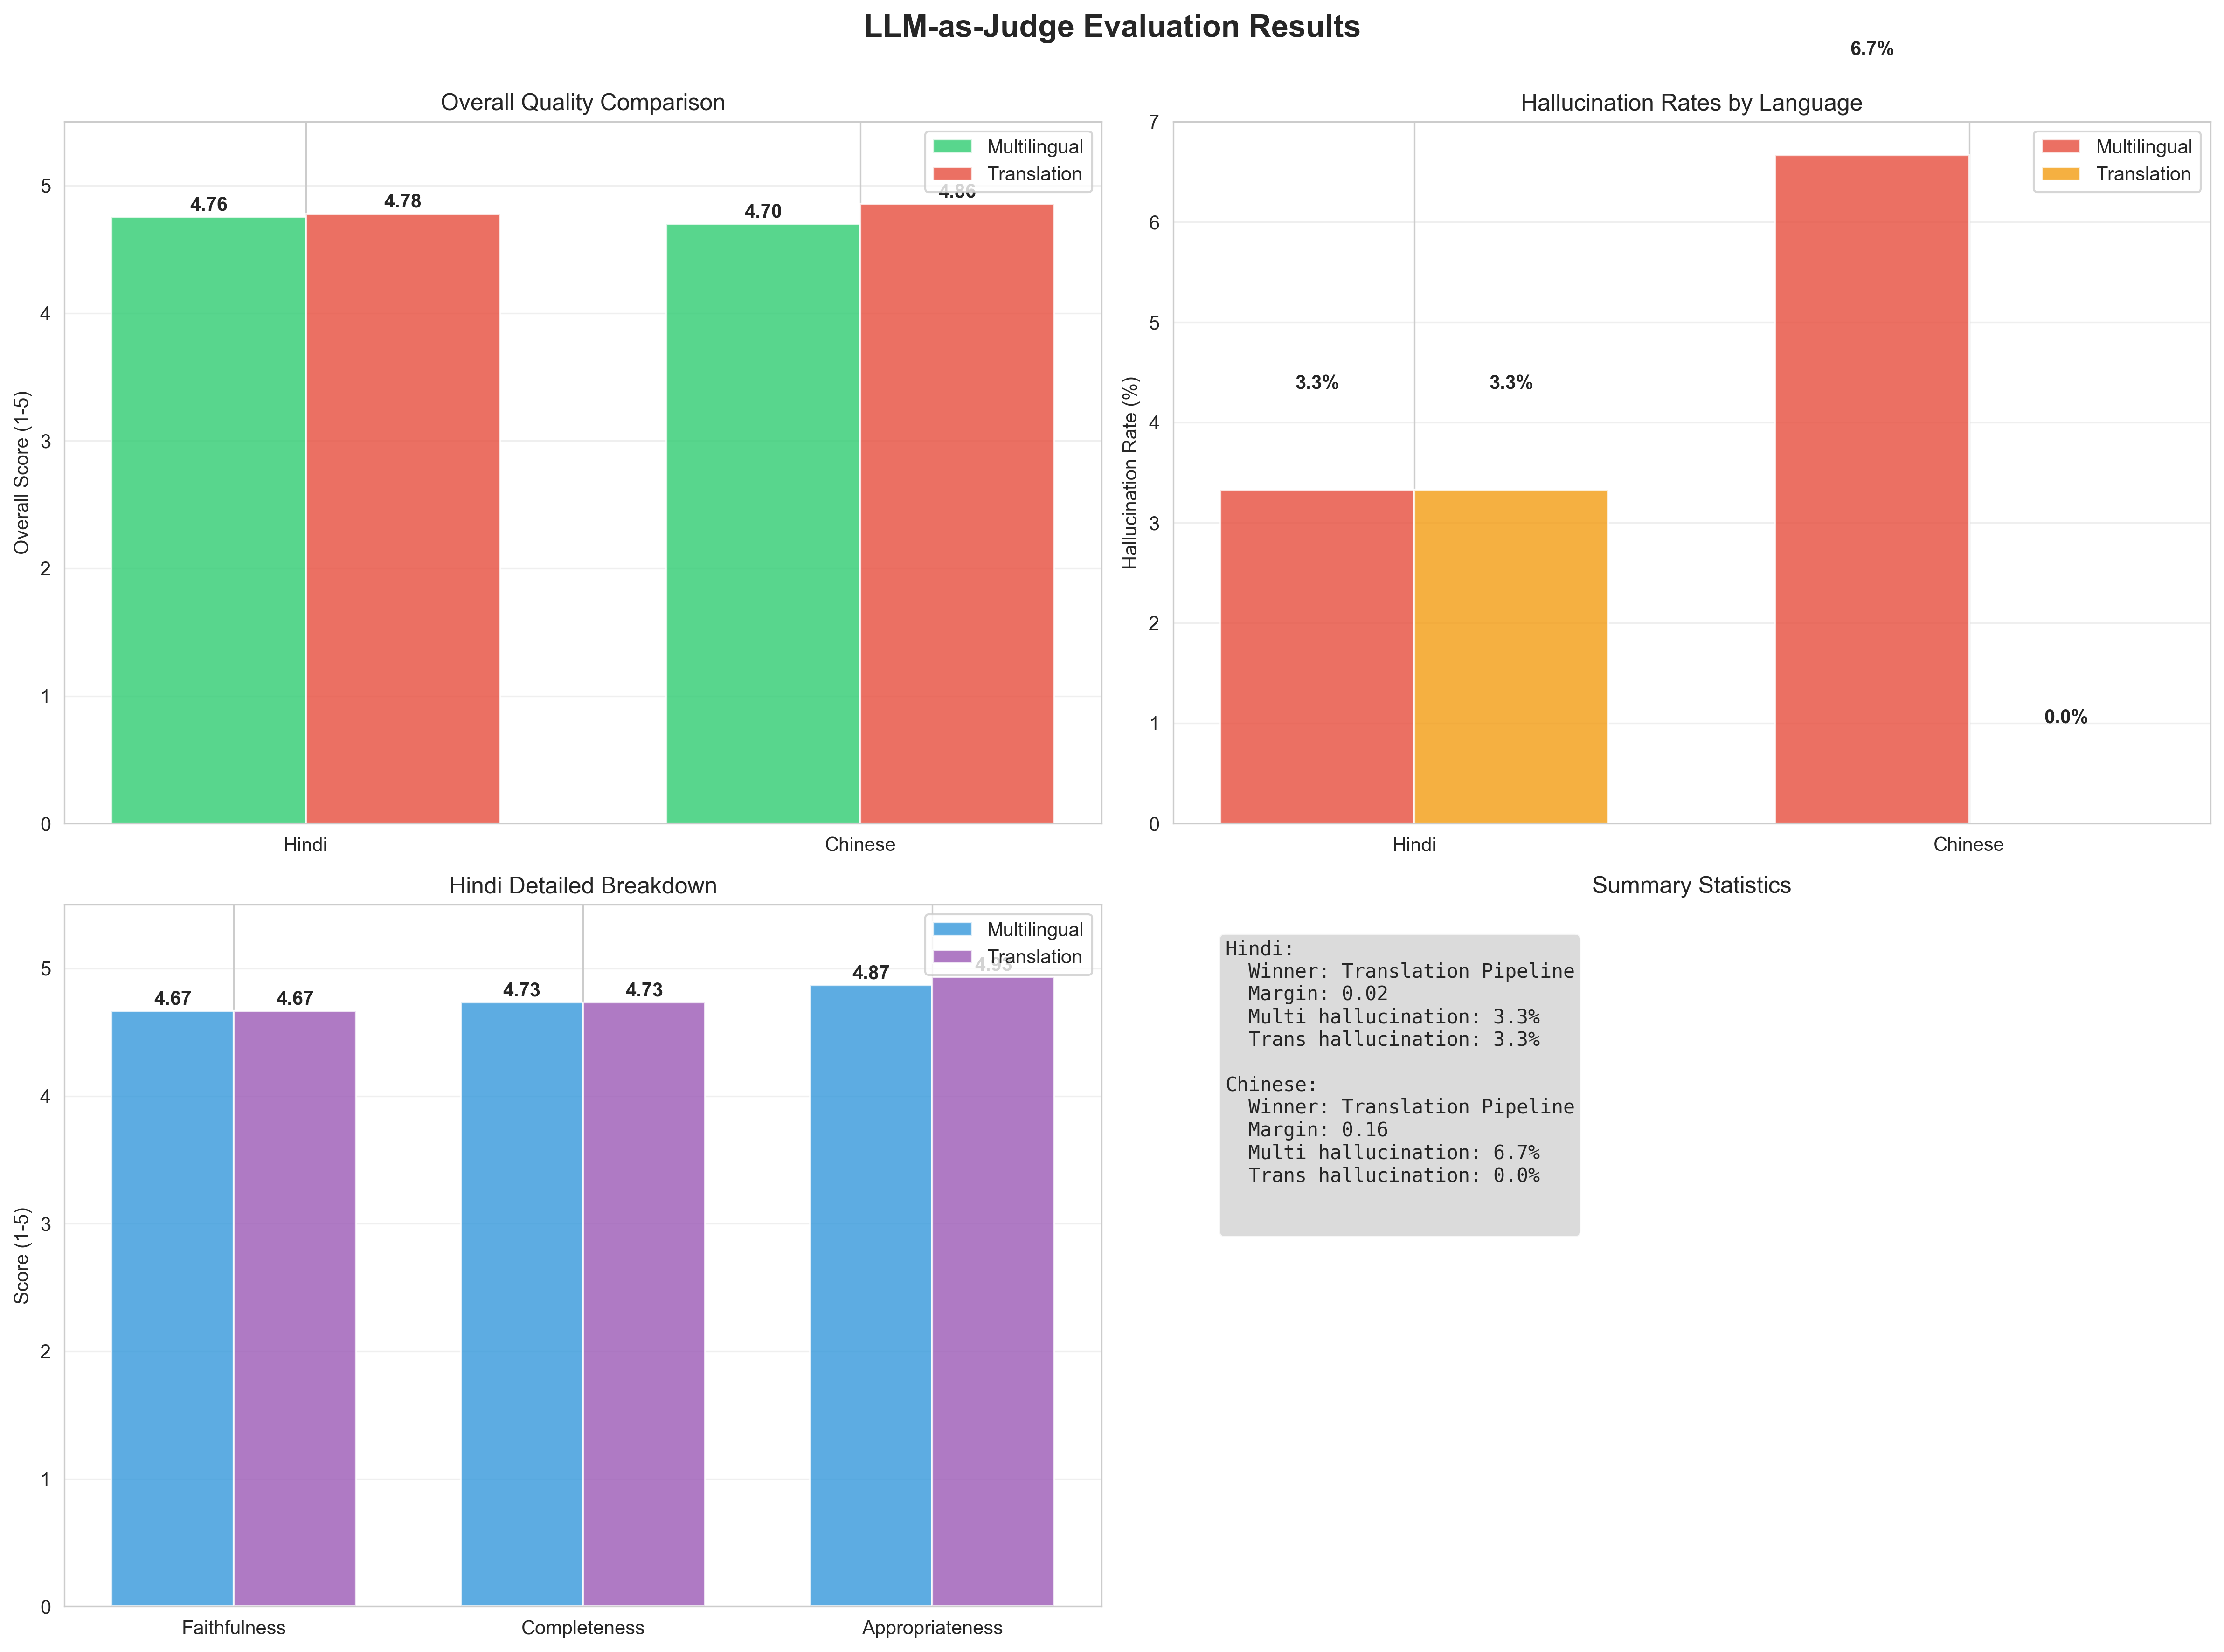


LLM-AS-JUDGE EVALUATION COMPLETE!

Generated files:
  1. C:\Users\Boris\Desktop\code\multilingual-rag\results\llm_judge_evaluation.csv
  2. C:\Users\Boris\Desktop\code\multilingual-rag\results\figures\llm_judge_comprehensive_analysis.png
  3. C:\Users\Boris\Desktop\code\multilingual-rag\results\llm_judge_final_summary.csv

🏆 FINAL RESULTS:

Hindi:
  🥇 Winner: Translation Pipeline (margin: +0.02)
  📊 Multilingual: 4.76/5 (hallucination: 3.3%)
  📊 Translation: 4.78/5 (hallucination: 3.3%)

Chinese:
  🥇 Winner: Translation Pipeline (margin: +0.16)
  📊 Multilingual: 4.70/5 (hallucination: 6.7%)
  📊 Translation: 4.86/5 (hallucination: 0.0%)

This resolves the contradiction between chunk quality and response quality!
Check the hallucination rates and overall scores to understand the difference.


In [1]:
# Notebook 5: LLM-as-Judge Evaluation - Hindi + Chinese
# Run this AFTER notebook 3 to evaluate response quality across languages

import sys
import os
sys.path.append('..')

# SET API KEY
OPEN_API_KEY = "YOUR KEY"
os.environ["OPENAI_API_KEY"] = OPEN_API_KEY

import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Dict, List
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import evaluate_with_llm_judge

logging.basicConfig(
    level=logging.WARNING,  # Reduce log noise
    format='%(asctime)s - %(levelname)s - %(message)s'
)

ROOT_DIR = Path('..').resolve()
RESULTS_DIR = ROOT_DIR / 'results'

print(f"Results directory: {RESULTS_DIR}")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load experiment results from notebook 3
results_file = RESULTS_DIR / 'multilingual_rag_results.csv'

if not results_file.exists():
    print("multilingual_rag_results.csv not found. Please run notebook 3 first.")
    raise FileNotFoundError("multilingual_rag_results.csv not found")

print(f"Loading: {results_file.name}")
df_results = pd.read_csv(results_file, encoding='utf-8')
print(f"Loaded {len(df_results)} experiment results")

# Split by language
df_hindi = df_results[df_results['language'] == 'Hindi'].copy()
df_chinese = df_results[df_results['language'] == 'Chinese'].copy()

print(f"Hindi results: {len(df_hindi)}")
print(f"Chinese results: {len(df_chinese)}")

# Check required columns
required_cols = [
    'question', 'question_english_reference',
    'multilingual_chunks', 'translation_chunks',
    'multilingual_response', 'translation_response',
    'multilingual_response_english_for_eval', 'translation_response_english_for_eval'
]

missing_cols = [col for col in required_cols if col not in df_results.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print("Available columns:", list(df_results.columns))
    print("Please re-run notebook 3 with updated rag_system.py that saves chunks")
    raise ValueError("Missing required columns for LLM-as-judge evaluation")

print("✓ All required columns present")

# Validate data quality
print("\nValidating data quality...")
for lang_name, df_lang in [("Hindi", df_hindi), ("Chinese", df_chinese)]:
    if len(df_lang) > 0:
        # Check for empty responses
        empty_multi = df_lang['multilingual_response'].isna().sum()
        empty_trans = df_lang['translation_response'].isna().sum()
        empty_chunks_multi = df_lang['multilingual_chunks'].isna().sum()
        empty_chunks_trans = df_lang['translation_chunks'].isna().sum()
        
        print(f"{lang_name}:")
        print(f"  Empty multilingual responses: {empty_multi}")
        print(f"  Empty translation responses: {empty_trans}")
        print(f"  Empty multilingual chunks: {empty_chunks_multi}")
        print(f"  Empty translation chunks: {empty_chunks_trans}")
        
        if empty_multi > 0 or empty_trans > 0 or empty_chunks_multi > 0 or empty_chunks_trans > 0:
            print(f"  ⚠️  Warning: Some data missing for {lang_name}")

# Run LLM-as-Judge Evaluation for specific language
def evaluate_language_responses(df_lang, language_name, language_code):
    """Run LLM-as-judge evaluation for a specific language"""
    print(f"\n{'='*80}")
    print(f"RUNNING LLM-AS-JUDGE EVALUATION FOR {language_name.upper()}")
    print(f"{'='*80}")
    
    evaluations = []
    total_questions = len(df_lang)
    
    for idx, row in df_lang.iterrows():
        question = row['question']
        question_english = row['question_english_reference']
        
        # Progress indicator (cleaner than tqdm)
        if (idx + 1) % 3 == 0 or idx == 0 or (idx + 1) == total_questions:
            print(f"\nProgress: [{idx+1}/{total_questions}] {question[:50]}...")
        
        try:
            # Evaluate Multilingual Approach
            eval_multi = evaluate_with_llm_judge(
                question_native=question,
                question_english=question_english,
                reference_text=str(row['multilingual_chunks']),
                answer_native=str(row['multilingual_response']),
                answer_english=str(row['multilingual_response_english_for_eval']),
                approach="Multilingual Embeddings",
                model="gpt-4o"
            )
            
            # Evaluate Translation Approach
            eval_trans = evaluate_with_llm_judge(
                question_native=question,
                question_english=question_english,
                reference_text=str(row['translation_chunks']),
                answer_native=str(row['translation_response']),
                answer_english=str(row['translation_response_english_for_eval']),
                approach="Translation Pipeline",
                model="gpt-4o"
            )
            
            if eval_multi and eval_trans:
                evaluation_result = {
                    'question_id': row['question_id'],
                    'language': language_name,
                    'question': question,
                    'question_english': question_english,
                    
                    # Multilingual scores
                    'multi_faithfulness_label': eval_multi['faithfulness']['label'],
                    'multi_faithfulness_score': eval_multi['faithfulness']['score'],
                    'multi_completeness_label': eval_multi['completeness']['label'],
                    'multi_completeness_score': eval_multi['completeness']['score'],
                    'multi_appropriateness_label': eval_multi['medical_appropriateness']['label'],
                    'multi_appropriateness_score': eval_multi['medical_appropriateness']['score'],
                    'multi_overall': eval_multi['overall_assessment'],
                    'multi_issues': '; '.join(eval_multi.get('key_issues', [])) if eval_multi.get('key_issues') else 'None',
                    
                    # Translation scores
                    'trans_faithfulness_label': eval_trans['faithfulness']['label'],
                    'trans_faithfulness_score': eval_trans['faithfulness']['score'],
                    'trans_completeness_label': eval_trans['completeness']['label'],
                    'trans_completeness_score': eval_trans['completeness']['score'],
                    'trans_appropriateness_label': eval_trans['medical_appropriateness']['label'],
                    'trans_appropriateness_score': eval_trans['medical_appropriateness']['score'],
                    'trans_overall': eval_trans['overall_assessment'],
                    'trans_issues': '; '.join(eval_trans.get('key_issues', [])) if eval_trans.get('key_issues') else 'None'
                }
                
                evaluations.append(evaluation_result)
                
                # Show progress scores
                if (idx + 1) % 3 == 0 or idx == 0 or (idx + 1) == total_questions:
                    print(f"    Multi: F={eval_multi['faithfulness']['score']}, C={eval_multi['completeness']['score']}, A={eval_multi['medical_appropriateness']['score']}")
                    print(f"    Trans: F={eval_trans['faithfulness']['score']}, C={eval_trans['completeness']['score']}, A={eval_trans['medical_appropriateness']['score']}")
            else:
                print(f"    ❌ Evaluation failed for question {idx+1}")
                
        except Exception as e:
            print(f"    ❌ Error evaluating question {idx+1}: {str(e)}")
            continue
    
    print(f"\n✓ Completed {len(evaluations)}/{total_questions} evaluations for {language_name}")
    return pd.DataFrame(evaluations)

# Run evaluations for both languages
all_evaluations = []

if len(df_hindi) > 0:
    hindi_evaluations = evaluate_language_responses(df_hindi, "Hindi", "hindi")
    if len(hindi_evaluations) > 0:
        all_evaluations.append(("Hindi", hindi_evaluations))

if len(df_chinese) > 0:
    chinese_evaluations = evaluate_language_responses(df_chinese, "Chinese", "chinese")
    if len(chinese_evaluations) > 0:
        all_evaluations.append(("Chinese", chinese_evaluations))

# Combine all evaluations
if all_evaluations:
    df_combined_llm_judge = pd.concat([eval_df for _, eval_df in all_evaluations], ignore_index=True)
    
    # Save combined results
    output_file = RESULTS_DIR / 'llm_judge_evaluation.csv'
    df_combined_llm_judge.to_csv(output_file, index=False, encoding='utf-8')
    print(f"\n✓ LLM-as-Judge evaluation complete!")
    print(f"  Saved to: {output_file}")
    print(f"  Evaluated: {len(df_combined_llm_judge)} questions across {len(all_evaluations)} languages")
else:
    print("❌ No evaluations completed successfully.")
    raise RuntimeError("No LLM-as-judge evaluations completed")

# Generate Summary Statistics for Each Language
def generate_language_summary(df_eval, language_name):
    """Generate summary statistics for a specific language"""
    print(f"\n{'='*80}")
    print(f"{language_name.upper()} LLM-AS-JUDGE EVALUATION SUMMARY")
    print(f"{'='*80}")
    
    # Count total questions
    total_q = len(df_eval)
    
    # Faithfulness (Hallucination)
    print(f"\n📊 FAITHFULNESS (Hallucination Detection):")
    print(f"\nMultilingual Embeddings:")
    print(f"  Average Score: {df_eval['multi_faithfulness_score'].mean():.2f}/5")
    multi_factual = (df_eval['multi_faithfulness_label'] == 'factual').sum()
    multi_halluc = (df_eval['multi_faithfulness_label'] == 'hallucinated').sum()
    multi_partial = (df_eval['multi_faithfulness_label'] == 'partial').sum()
    print(f"  Factual: {multi_factual}/{total_q} ({multi_factual/total_q*100:.1f}%)")
    print(f"  Hallucinated: {multi_halluc}/{total_q} ({multi_halluc/total_q*100:.1f}%)")
    print(f"  Partial: {multi_partial}/{total_q} ({multi_partial/total_q*100:.1f}%)")
    
    print(f"\nTranslation Pipeline:")
    print(f"  Average Score: {df_eval['trans_faithfulness_score'].mean():.2f}/5")
    trans_factual = (df_eval['trans_faithfulness_label'] == 'factual').sum()
    trans_halluc = (df_eval['trans_faithfulness_label'] == 'hallucinated').sum()
    trans_partial = (df_eval['trans_faithfulness_label'] == 'partial').sum()
    print(f"  Factual: {trans_factual}/{total_q} ({trans_factual/total_q*100:.1f}%)")
    print(f"  Hallucinated: {trans_halluc}/{total_q} ({trans_halluc/total_q*100:.1f}%)")
    print(f"  Partial: {trans_partial}/{total_q} ({trans_partial/total_q*100:.1f}%)")
    
    # Completeness
    print(f"\n📋 COMPLETENESS (Information Coverage):")
    print(f"\nMultilingual Embeddings:")
    print(f"  Average Score: {df_eval['multi_completeness_score'].mean():.2f}/5")
    multi_complete = (df_eval['multi_completeness_label'] == 'complete').sum()
    print(f"  Complete: {multi_complete}/{total_q} ({multi_complete/total_q*100:.1f}%)")
    
    print(f"\nTranslation Pipeline:")
    print(f"  Average Score: {df_eval['trans_completeness_score'].mean():.2f}/5")
    trans_complete = (df_eval['trans_completeness_label'] == 'complete').sum()
    print(f"  Complete: {trans_complete}/{total_q} ({trans_complete/total_q*100:.1f}%)")
    
    # Medical Appropriateness
    print(f"\n⚕️ MEDICAL APPROPRIATENESS:")
    print(f"\nMultilingual Embeddings:")
    print(f"  Average Score: {df_eval['multi_appropriateness_score'].mean():.2f}/5")
    multi_appropriate = (df_eval['multi_appropriateness_label'] == 'appropriate').sum()
    multi_harmful = (df_eval['multi_appropriateness_label'] == 'potentially_harmful').sum()
    print(f"  Appropriate: {multi_appropriate}/{total_q} ({multi_appropriate/total_q*100:.1f}%)")
    if multi_harmful > 0:
        print(f"  ⚠️  Potentially Harmful: {multi_harmful}/{total_q} ({multi_harmful/total_q*100:.1f}%)")
    
    print(f"\nTranslation Pipeline:")
    print(f"  Average Score: {df_eval['trans_appropriateness_score'].mean():.2f}/5")
    trans_appropriate = (df_eval['trans_appropriateness_label'] == 'appropriate').sum()
    trans_harmful = (df_eval['trans_appropriateness_label'] == 'potentially_harmful').sum()
    print(f"  Appropriate: {trans_appropriate}/{total_q} ({trans_appropriate/total_q*100:.1f}%)")
    if trans_harmful > 0:
        print(f"  ⚠️  Potentially Harmful: {trans_harmful}/{total_q} ({trans_harmful/total_q*100:.1f}%)")
    
    # Overall Comparison
    multi_avg = (df_eval['multi_faithfulness_score'].mean() + 
                 df_eval['multi_completeness_score'].mean() + 
                 df_eval['multi_appropriateness_score'].mean()) / 3
    
    trans_avg = (df_eval['trans_faithfulness_score'].mean() + 
                 df_eval['trans_completeness_score'].mean() + 
                 df_eval['trans_appropriateness_score'].mean()) / 3
    
    print(f"\n🏆 OVERALL COMPARISON:")
    print(f"  Multilingual Embeddings: {multi_avg:.2f}/5")
    print(f"  Translation Pipeline: {trans_avg:.2f}/5")
    
    winner = "Translation Pipeline" if trans_avg > multi_avg else "Multilingual Embeddings"
    margin = abs(trans_avg - multi_avg)
    
    if margin < 0.1:
        print(f"  Result: TIE (difference: {margin:.2f})")
    else:
        print(f"  🥇 WINNER: {winner} (margin: +{margin:.2f})")
    
    return {
        'language': language_name,
        'total_questions': total_q,
        'multi_avg': multi_avg,
        'trans_avg': trans_avg,
        'winner': winner,
        'margin': margin,
        'multi_hallucination_rate': multi_halluc/total_q*100,
        'trans_hallucination_rate': trans_halluc/total_q*100
    }

# Generate summaries for each language
language_summaries = []
for language_name, df_eval in all_evaluations:
    summary = generate_language_summary(df_eval, language_name)
    language_summaries.append(summary)

# Cross-Language Comparison
if len(all_evaluations) >= 2:
    print(f"\n{'='*80}")
    print("CROSS-LANGUAGE COMPARISON")
    print(f"{'='*80}")
    
    comparison_data = []
    for language_name, df_eval in all_evaluations:
        comparison_data.append({
            'Language': language_name,
            'Questions': len(df_eval),
            'Multi_Overall': f"{((df_eval['multi_faithfulness_score'].mean() + df_eval['multi_completeness_score'].mean() + df_eval['multi_appropriateness_score'].mean()) / 3):.2f}",
            'Trans_Overall': f"{((df_eval['trans_faithfulness_score'].mean() + df_eval['trans_completeness_score'].mean() + df_eval['trans_appropriateness_score'].mean()) / 3):.2f}",
            'Multi_Hallucination': f"{((df_eval['multi_faithfulness_label'] == 'hallucinated').sum() / len(df_eval) * 100):.1f}%",
            'Trans_Hallucination': f"{((df_eval['trans_faithfulness_label'] == 'hallucinated').sum() / len(df_eval) * 100):.1f}%",
            'Winner': 'Translation' if ((df_eval['trans_faithfulness_score'].mean() + df_eval['trans_completeness_score'].mean() + df_eval['trans_appropriateness_score'].mean()) / 3) > ((df_eval['multi_faithfulness_score'].mean() + df_eval['multi_completeness_score'].mean() + df_eval['multi_appropriateness_score'].mean()) / 3) else 'Multilingual'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

# Generate Visualizations
figures_dir = RESULTS_DIR / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*80}")
print("GENERATING LLM-AS-JUDGE VISUALIZATIONS")
print(f"{'='*80}")

# Main comparison visualization
if len(all_evaluations) >= 1:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('LLM-as-Judge Evaluation Results', fontsize=16, fontweight='bold')
    
    # Prepare data for visualization
    languages = [lang for lang, _ in all_evaluations]
    
    # Overall scores comparison
    ax1 = axes[0, 0]
    multi_overall = []
    trans_overall = []
    
    for _, df_eval in all_evaluations:
        multi_score = (df_eval['multi_faithfulness_score'].mean() + 
                      df_eval['multi_completeness_score'].mean() + 
                      df_eval['multi_appropriateness_score'].mean()) / 3
        trans_score = (df_eval['trans_faithfulness_score'].mean() + 
                      df_eval['trans_completeness_score'].mean() + 
                      df_eval['trans_appropriateness_score'].mean()) / 3
        multi_overall.append(multi_score)
        trans_overall.append(trans_score)
    
    x = np.arange(len(languages))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, multi_overall, width, label='Multilingual', color='#2ecc71', alpha=0.8)
    bars2 = ax1.bar(x + width/2, trans_overall, width, label='Translation', color='#e74c3c', alpha=0.8)
    
    # Add value labels
    for i, (m_score, t_score) in enumerate(zip(multi_overall, trans_overall)):
        ax1.text(i - width/2, m_score + 0.05, f'{m_score:.2f}', ha='center', fontweight='bold')
        ax1.text(i + width/2, t_score + 0.05, f'{t_score:.2f}', ha='center', fontweight='bold')
    
    ax1.set_ylabel('Overall Score (1-5)')
    ax1.set_title('Overall Quality Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(languages)
    ax1.set_ylim([0, 5.5])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Hallucination rates
    ax2 = axes[0, 1]
    multi_hall = []
    trans_hall = []
    
    for _, df_eval in all_evaluations:
        multi_hall.append((df_eval['multi_faithfulness_label'] == 'hallucinated').sum() / len(df_eval) * 100)
        trans_hall.append((df_eval['trans_faithfulness_label'] == 'hallucinated').sum() / len(df_eval) * 100)
    
    bars3 = ax2.bar(x - width/2, multi_hall, width, label='Multilingual', color='#e74c3c', alpha=0.8)
    bars4 = ax2.bar(x + width/2, trans_hall, width, label='Translation', color='#f39c12', alpha=0.8)
    
    for i, (m_rate, t_rate) in enumerate(zip(multi_hall, trans_hall)):
        ax2.text(i - width/2, m_rate + 1, f'{m_rate:.1f}%', ha='center', fontweight='bold')
        ax2.text(i + width/2, t_rate + 1, f'{t_rate:.1f}%', ha='center', fontweight='bold')
    
    ax2.set_ylabel('Hallucination Rate (%)')
    ax2.set_title('Hallucination Rates by Language')
    ax2.set_xticks(x)
    ax2.set_xticklabels(languages)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Detailed breakdown for first language
    if len(all_evaluations) > 0:
        first_lang, first_df = all_evaluations[0]
        
        ax3 = axes[1, 0]
        categories = ['Faithfulness', 'Completeness', 'Appropriateness']
        multi_scores = [
            first_df['multi_faithfulness_score'].mean(),
            first_df['multi_completeness_score'].mean(),
            first_df['multi_appropriateness_score'].mean()
        ]
        trans_scores = [
            first_df['trans_faithfulness_score'].mean(),
            first_df['trans_completeness_score'].mean(),
            first_df['trans_appropriateness_score'].mean()
        ]
        
        x_cat = np.arange(len(categories))
        bars5 = ax3.bar(x_cat - width/2, multi_scores, width, label='Multilingual', color='#3498db', alpha=0.8)
        bars6 = ax3.bar(x_cat + width/2, trans_scores, width, label='Translation', color='#9b59b6', alpha=0.8)
        
        for i, (m_score, t_score) in enumerate(zip(multi_scores, trans_scores)):
            ax3.text(i - width/2, m_score + 0.05, f'{m_score:.2f}', ha='center', fontweight='bold')
            ax3.text(i + width/2, t_score + 0.05, f'{t_score:.2f}', ha='center', fontweight='bold')
        
        ax3.set_ylabel('Score (1-5)')
        ax3.set_title(f'{first_lang} Detailed Breakdown')
        ax3.set_xticks(x_cat)
        ax3.set_xticklabels(categories)
        ax3.set_ylim([0, 5.5])
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
    # Summary statistics
    ax4 = axes[1, 1]
    if len(language_summaries) > 0:
        summary_text = ""
        for summary in language_summaries:
            summary_text += f"{summary['language']}:\n"
            summary_text += f"  Winner: {summary['winner']}\n"
            summary_text += f"  Margin: {summary['margin']:.2f}\n"
            summary_text += f"  Multi hallucination: {summary['multi_hallucination_rate']:.1f}%\n"
            summary_text += f"  Trans hallucination: {summary['trans_hallucination_rate']:.1f}%\n\n"
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax4.set_title('Summary Statistics')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'llm_judge_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: llm_judge_comprehensive_analysis.png")
    plt.show()

# Save final summary
final_summary_data = []
for summary in language_summaries:
    final_summary_data.append({
        'Language': summary['language'],
        'Total_Questions': summary['total_questions'],
        'Multilingual_Overall': f"{summary['multi_avg']:.2f}",
        'Translation_Overall': f"{summary['trans_avg']:.2f}",
        'Winner': summary['winner'],
        'Margin': f"{summary['margin']:.2f}",
        'Multi_Hallucination_Rate': f"{summary['multi_hallucination_rate']:.1f}%",
        'Trans_Hallucination_Rate': f"{summary['trans_hallucination_rate']:.1f}%"
    })

final_summary_df = pd.DataFrame(final_summary_data)
final_summary_path = RESULTS_DIR / 'llm_judge_final_summary.csv'
final_summary_df.to_csv(final_summary_path, index=False)

print(f"\n{'='*80}")
print("LLM-AS-JUDGE EVALUATION COMPLETE!")
print(f"{'='*80}")

print(f"\nGenerated files:")
print(f"  1. {output_file}")
print(f"  2. {figures_dir / 'llm_judge_comprehensive_analysis.png'}")
print(f"  3. {final_summary_path}")

print(f"\n🏆 FINAL RESULTS:")
for summary in language_summaries:
    print(f"\n{summary['language']}:")
    print(f"  🥇 Winner: {summary['winner']} (margin: +{summary['margin']:.2f})")
    print(f"  📊 Multilingual: {summary['multi_avg']:.2f}/5 (hallucination: {summary['multi_hallucination_rate']:.1f}%)")
    print(f"  📊 Translation: {summary['trans_avg']:.2f}/5 (hallucination: {summary['trans_hallucination_rate']:.1f}%)")

print(f"\n{'='*80}")
print("This resolves the contradiction between chunk quality and response quality!")
print("Check the hallucination rates and overall scores to understand the difference.")
print(f"{'='*80}")